# SMAI Assignment - 2

## Question - `2` : Face Recognition using Principal Component Analysis

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `16.02.2023` |
| Due Date | `24.02.2023` |

### <b>Objective:</b>
This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA) 
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

### <b>About the dataset:</b>  
The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)



### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.


#### Import Libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import warnings
warnings.filterwarnings('ignore')

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [ ]:
# function to plot images from vector representaion of pixels.
def plot_vectors(vectors, x, y):
  plot = []
  for v in vectors:
    v=((v - v.min()) / (v.max() - v.min()))*255
    img = np.reshape(v, (x, y))
    plot.append(img)
    if(len(plot)==16):
      cv2_imshow(np.hstack(plot))
      plot=[]
  if(len(plot)!=0):
    cv2_imshow(np.hstack(plot))

In [ ]:
!unzip ATnT.zip

Archive:  ATnT.zip
  inflating: ATnT/README             
   creating: ATnT/s1/
  inflating: ATnT/s1/1.pgm           
  inflating: ATnT/s1/10.pgm          
  inflating: ATnT/s1/2.pgm           
  inflating: ATnT/s1/3.pgm           
  inflating: ATnT/s1/4.pgm           
  inflating: ATnT/s1/5.pgm           
  inflating: ATnT/s1/6.pgm           
  inflating: ATnT/s1/7.pgm           
  inflating: ATnT/s1/8.pgm           
  inflating: ATnT/s1/9.pgm           
   creating: ATnT/s10/
  inflating: ATnT/s10/1.pgm          
  inflating: ATnT/s10/10.pgm         
  inflating: ATnT/s10/2.pgm          
  inflating: ATnT/s10/3.pgm          
  inflating: ATnT/s10/4.pgm          
  inflating: ATnT/s10/5.pgm          
  inflating: ATnT/s10/6.pgm          
  inflating: ATnT/s10/7.pgm          
  inflating: ATnT/s10/8.pgm          
  inflating: ATnT/s10/9.pgm          
   creating: ATnT/s11/
  inflating: ATnT/s11/1.pgm          
  inflating: ATnT/s11/10.pgm         
  inflating: ATnT/s11/2.pgm          
 

<IPython.core.display.Javascript object>

320 Training Faces


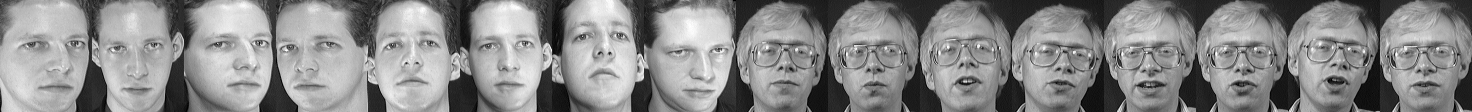

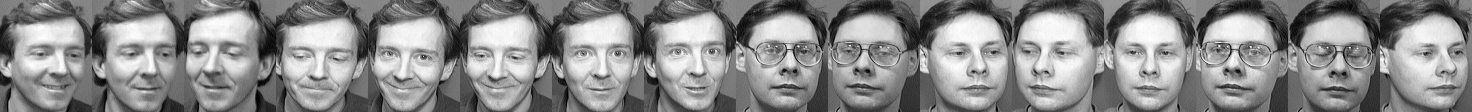

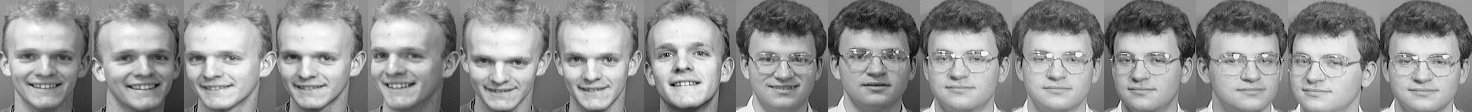

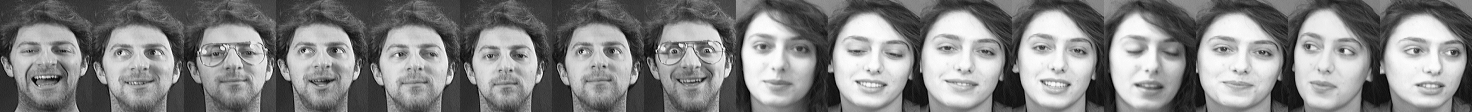

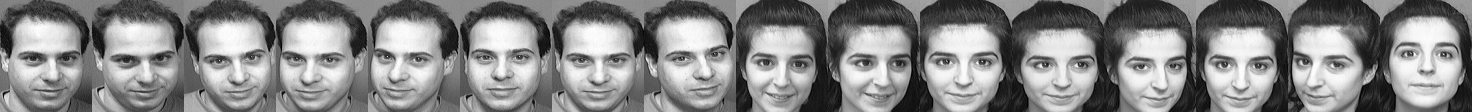

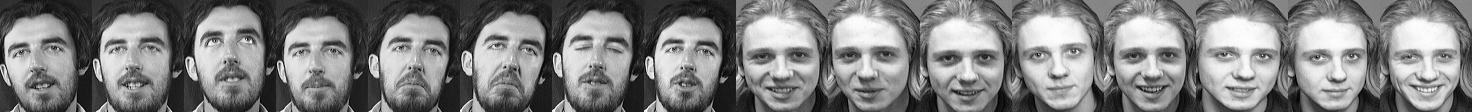

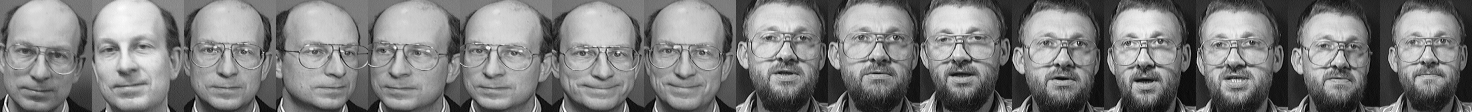

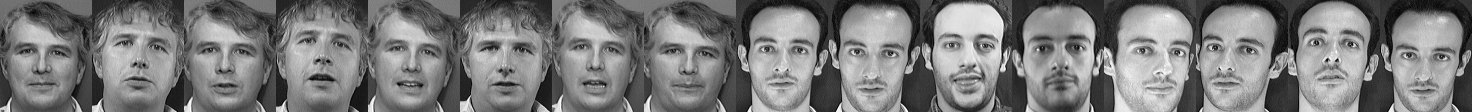

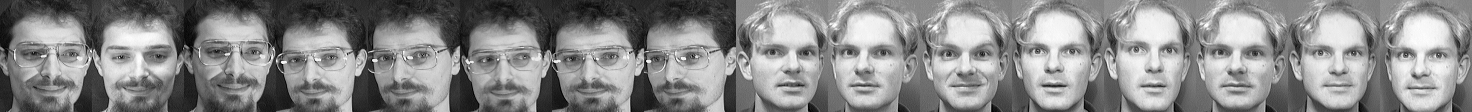

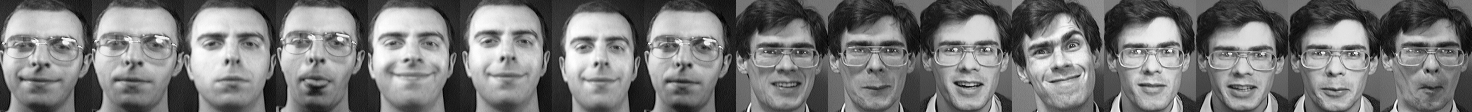

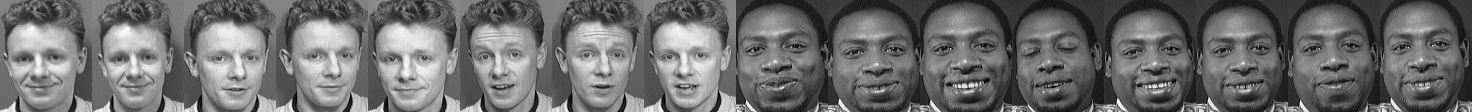

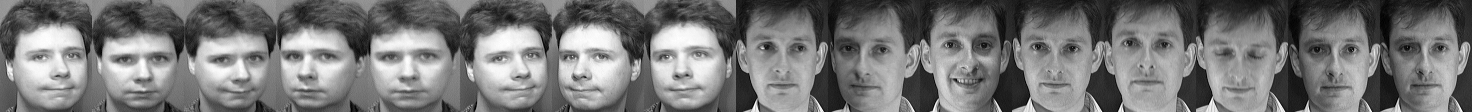

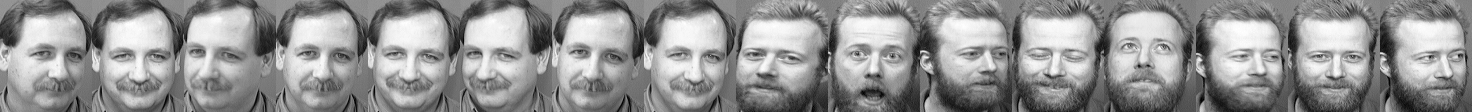

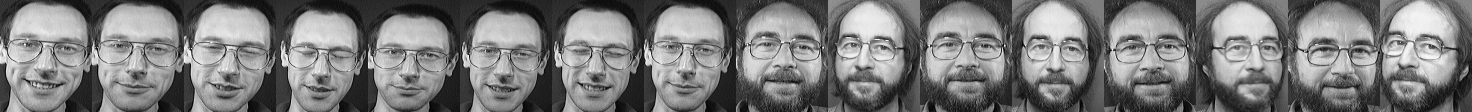

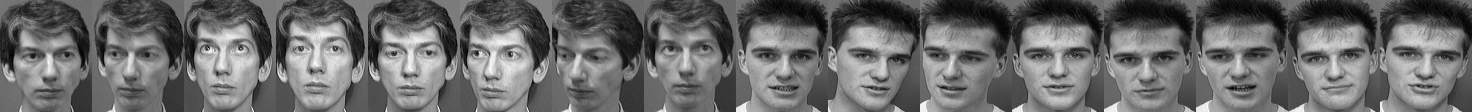

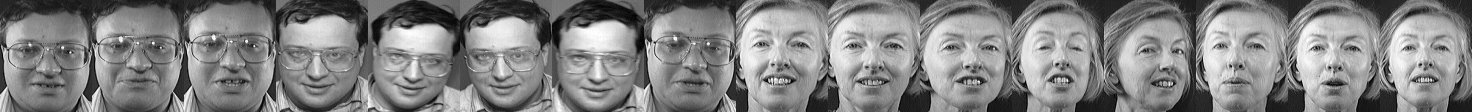

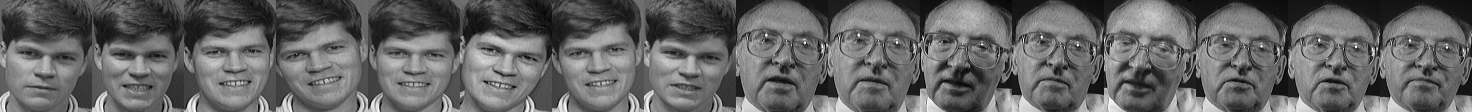

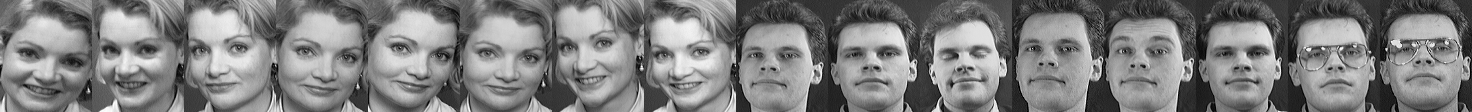

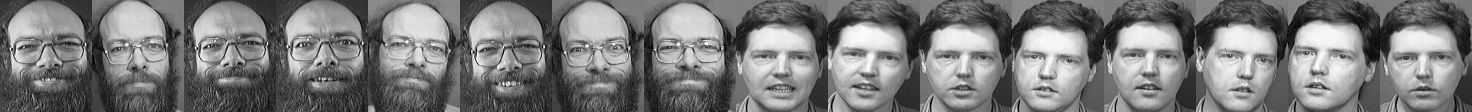

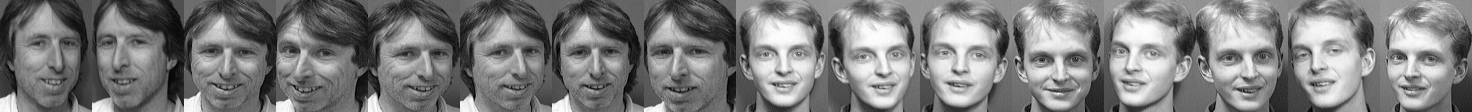

In [ ]:
# reading the images and making train and test data.
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

os.chdir("ATnT")

testX = []
testy = []
trainX = []
trainy = []

rand_two = list(np.random.choice(10, 2, replace = False))
for i in range(1, 41):
  os.chdir(f"s{i}")
  for j in range(1, 11):
    img = cv2.imread(f'{j}.pgm')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.reshape(img, (img.shape[0] * img.shape[1]))
    if j-1 in rand_two:
      testX.append(img)
      testy.append(i)
    else:
      trainX.append(img)
      trainy.append(i)
  os.chdir("..")

print(len(trainX),"Training Faces")
plot_vectors(trainX, 112, 92)

In [ ]:
# converting to numpy arrays
trainX = np.array(trainX)
trainy = np.array(trainy)
testX = np.array(testX)
testy = np.array(testy)
shuffled_indexs = np.random.permutation(testX.shape[0])
testX = testX[shuffled_indexs]
testy = testy[shuffled_indexs]
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

(320, 10304) (320,) (80, 10304) (80,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [ ]:
"""
Implement pca in the following function by taking the following arguements:
1. X(images array)
2. number of components
The function must return the eigen vectors (principal components) also termed "Eigen faces"
"""
def principalComponentAnalysis(X, number_of_components):
  mean = np.mean(X, axis=0)       # Finding mean face.
  X = X.astype('float64')
  X -= mean                       # Subtracting mean face from all faces.
  covariance = np.cov(X.T)        # Computing the covariance matrix of the flattened image matrix. 
  eigval, eigvec = np.linalg.eigh(covariance)         # Finding eigenvectors and eigenvalues of the covariance matrix.
  sorted_ind = np.argsort(eigval)[::-1]               # Sorting eigenvectors according to eigenvalues
  eigvec = eigvec[:,sorted_ind]
  return  eigvec[:,0:number_of_components].T, mean

In [ ]:
# Experimenting with random small dataset.
data = np.random.random((4, 3))
print(data[0:10])
eigvecs, mean = principalComponentAnalysis(data, 2)
print(eigvecs)
print(mean)

[[0.27193675 0.06935893 0.19051108]
 [0.73606812 0.65041957 0.59378387]
 [0.17388356 0.12249036 0.5796791 ]
 [0.84051356 0.28204831 0.55376554]]
[[-0.76555586 -0.57145156 -0.29557967]
 [-0.57727545  0.40729596  0.70771679]]
[0.5056005  0.28107929 0.4794349 ]


In [ ]:
# Calling my implemented PCA with trainX
eigfaces, mean = principalComponentAnalysis(trainX, 112*92)

Mean face


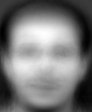

Mean of first 10 eigen face


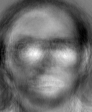

Top 32 EigenFaces in decreasing order of variance captured


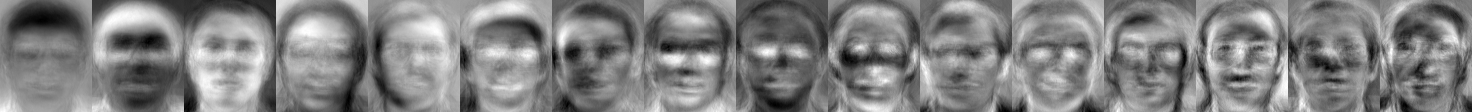

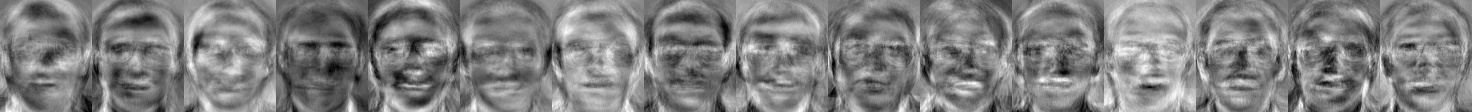

In [ ]:
print("Mean face")
plot_vectors((mean,), 112, 92)
print("Mean of first 10 eigen face")
plot_vectors((np.mean(eigfaces[:10], axis = 0),), 112, 92)
print('Top 32 EigenFaces in decreasing order of variance captured')
plot_vectors(eigfaces[:32], 112, 92)

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [ ]:
# Function to implement image reconstruction by taking arguements as necessary.
def imageReconstruction(X, mean, eigfaces):
  X = X.astype('float64')
  X -= mean
  components_range = [10304, 500, 250, 100, 50, 15, 5]
  for n in components_range:
    projected = np.dot(X, eigfaces[:n].T)             # Projecting our images to n dimensions
    reconstruction = np.dot(projected, eigfaces[:n])  # reconstructing our images by getting dot product of projection and eigenfaces
    print(f'Reconstruction using {n} Eigenfaces')
    plot_vectors(reconstruction + mean, 112, 92)

#### Visualisation
Visualise the results for different number of principal components(pc = 5,10,100, 1000, all).

**Note:** Ensure that the images are labelled appropriately.

Original 10 Selected Faces


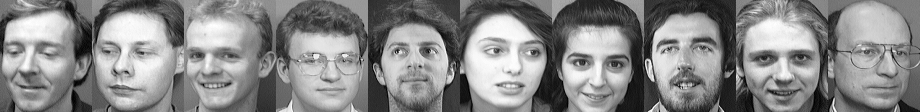

In [ ]:
# selecting one face from 10 subjects.
unique_faces = trainX[range(18, 100, 9)]
print('Original 10 Selected Faces')
plot_vectors(unique_faces, 112, 92)

Reconstruction using 10304 Eigenfaces


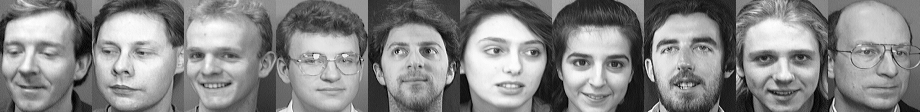

Reconstruction using 500 Eigenfaces


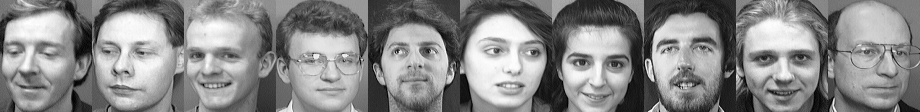

Reconstruction using 250 Eigenfaces


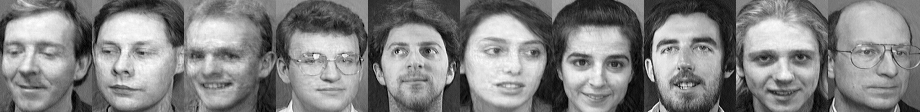

Reconstruction using 100 Eigenfaces


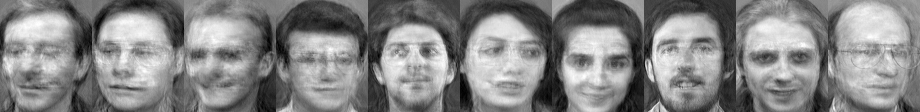

Reconstruction using 50 Eigenfaces


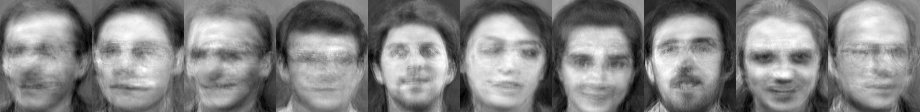

Reconstruction using 15 Eigenfaces


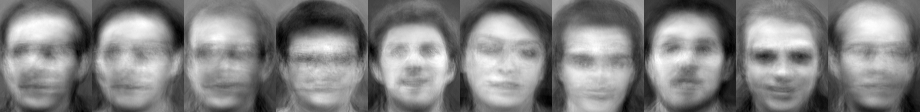

Reconstruction using 5 Eigenfaces


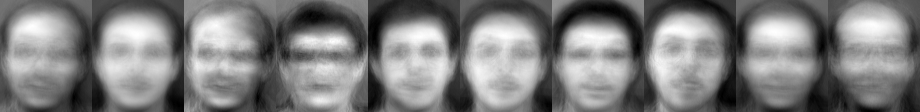

In [ ]:
# Visualising the results for different number of principal components
imageReconstruction(unique_faces, mean, eigfaces)

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [ ]:
"""
Implement pca in the following function by taking the following arguements:
1. Test image
2. Eigenvectors
3. Mean Eigen Face
4. Training Set(X_train,y_train)
The function must return the following:
1. image with smallest error
2. error value
3. prediction class
"""
def model(img_v, eigfaces, mean, X, y):
  # computing projection of X on eigenfaces
  projection = np.dot(X-mean, eigfaces.T)
  # computing projection of test image on eigenfaces
  img_projection = np.dot(img_v-mean, eigfaces.T)
  # finding the euclidian distances of all the projected image with the projected test image.
  euclid_distances = np.linalg.norm(projection - img_projection, axis = 1)
  # finding the image with lowest euclidian distance.
  ind = np.argmin(euclid_distances)
  return X[ind], euclid_distances[ind]/eigfaces.shape[0], y[ind]

test image  matched image


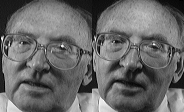

0.2611037801961781 34 34
test image  matched image


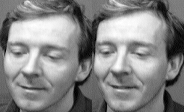

0.2793930942920268 3 3
test image  matched image


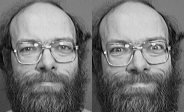

0.21261423050282083 37 37
test image  matched image


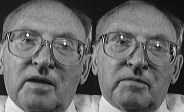

0.26859600462434485 34 34
test image  matched image


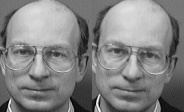

0.23158280696515088 13 13
test image  matched image


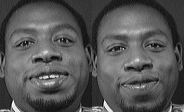

0.2989453706202411 22 22
test image  matched image


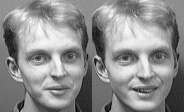

0.3007440379453267 40 40
test image  matched image


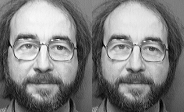

0.18871618430975706 28 28
test image  matched image


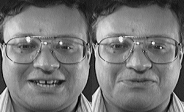

0.18139830541533106 31 31
test image  matched image


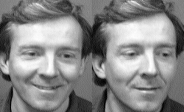

0.27639761775723914 3 3
test image  matched image


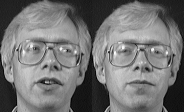

0.18479583532017976 2 2
test image  matched image


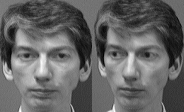

0.21129021303028092 29 29
test image  matched image


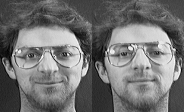

0.2941631159177987 7 7
test image  matched image


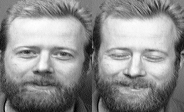

0.25163122381540953 26 26
test image  matched image


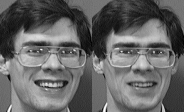

0.24436154004560048 20 20
test image  matched image


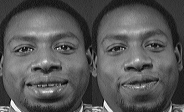

0.21693764360016993 22 22
test image  matched image


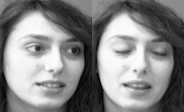

0.2635505603754047 8 8
test image  matched image


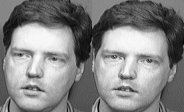

0.21585386915274138 38 38
test image  matched image


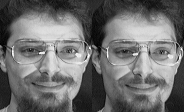

0.21994562343138957 17 17
test image  matched image


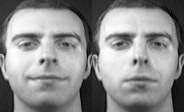

0.13855518065912284 19 19
test image  matched image


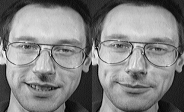

0.22591162419547148 27 27
test image  matched image


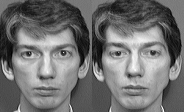

0.2323856789513562 29 29
test image  matched image


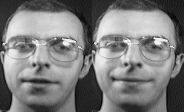

0.1807716875598846 19 19
test image  matched image


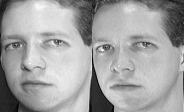

0.3423402311654894 1 1
test image  matched image


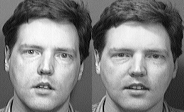

0.2754823259320718 38 38
test image  matched image


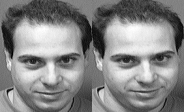

0.20961036727586677 9 9
test image  matched image


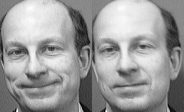

0.20668720003265476 13 13
test image  matched image


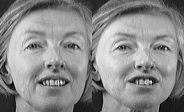

0.33996892690047487 32 32
test image  matched image


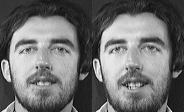

0.2926100926050595 11 11
test image  matched image


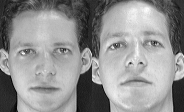

0.35348417324545356 1 1
test image  matched image


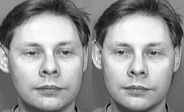

0.19519259778770015 4 4
test image  matched image


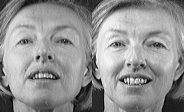

0.3521551187926038 32 32
test image  matched image


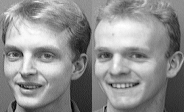

0.2560654538636693 5 40
test image  matched image


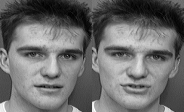

0.19419960533437977 30 30
test image  matched image


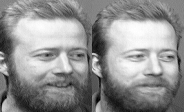

0.22803011549636418 26 26
test image  matched image


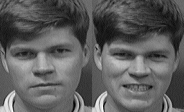

0.2898072567448108 33 33
test image  matched image


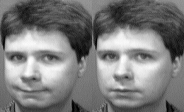

0.13390363858970955 23 23
test image  matched image


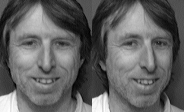

0.26445212321072575 39 39
test image  matched image


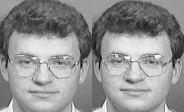

0.17918886828718014 6 6
test image  matched image


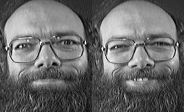

0.3217494049147927 37 37
97.5% correct_predictions


In [ ]:
# testing on test images
count = 0
for i in range(0, 40):
  print('test image  matched image')
  plot = []
  matched, error, label = model(testX[i], eigfaces, mean, trainX, trainy)
  plot.append(testX[i])
  plot.append(matched)
  plot_vectors(plot, 112, 92)
  print(error, label, testy[i])
  if label == testy[i]:
    count+=1
print(f"{count/40*100}% correct_predictions")

Heighest accuracy is 100.0%


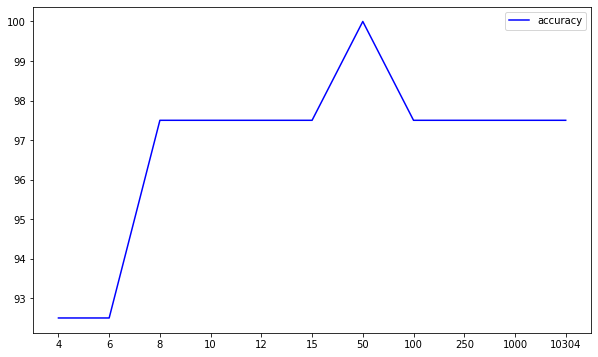

In [ ]:
"""
Iterate through all the images in the test data and 
test the accurate by taking different number of components
"""
components_range = [4, 6, 8, 10, 12, 15, 50, 100, 250, 1000, 10304]
accuracies = [] 
mean_errors = []
for n in components_range:
  errors = 0
  count = 0
  for i in range(0, 40):
    plot = []
    matched, error, label = model(testX[i], eigfaces[0:n], mean, trainX, trainy)
    if label == testy[i]:
      count+=1
    errors += error
  accuracies.append(count/40*100)
  mean_errors.append(errors/40)

max_acc = max(accuracies)
indxs = [accuracies == max_acc]
print(f'Heighest accuracy is {max_acc}%')

components_range = [str(val) for val in components_range]
plt.figure(figsize = (10, 6))
plt.plot(components_range, accuracies, color = 'blue', label = 'accuracy')
plt.legend()
plt.show()

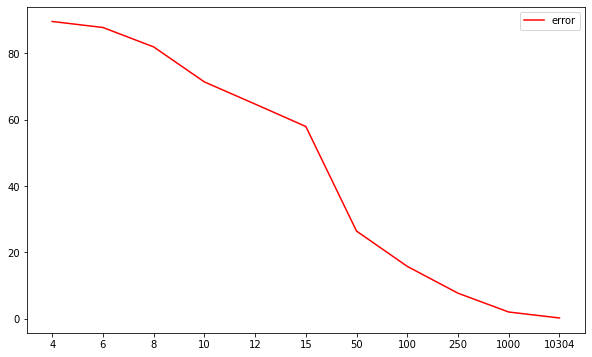

In [ ]:
# Plot Number of eigenvectors vs Mean Square Error
plt.figure(figsize = (10, 6))
plt.plot(components_range, mean_errors, color = 'red', label = 'error')
plt.legend()
plt.show()

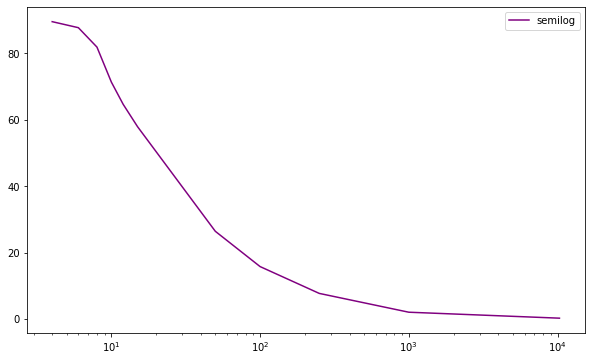

In [ ]:
# Plot Number of eigenvectors vs Logarithmic Mean Square Error
components_range_i = [int(val) for val in components_range]
plt.figure(figsize = (10, 6))
plt.semilogx(components_range_i, mean_errors, color = 'purple', label = 'semilog')
plt.legend()
plt.show()

Summarise your observations on the plots and accuracies

**Answer:**

With Increase in number of components(eigenfaces) for recognition the accuracy increases as more features or properties of images can be captured if the components are more and hence can differentiate better for recognition.

As a result, the predicted values for each face become more accurate, leading to a decrease in the MSE. This is because the algorithm is better able to reconstruct each face using the additional information provided by the additional components.

State the advantages and limitations of using PCA in general. Also state its limitations in context of face recognition

**Answer:**

**Advantages:**
PCA can reduce the dimensionality of a high-dimensional dataset while retaining most of the information in the original data, making it easier to visualize and analyze the data.
It can help remove noisy and redundant features from the data, which can improve the performance of machine learning algorithms.
It is a fast and computationally efficient algorithm that can be easily implemented.

**Limitations:**
PCA assumes that the data is linearly separable and normally distributed, which may not always be the case in real-world datasets.
It is sensitive to outliers in the data and may produce poor results if the data contains a large number of outliers.
It can result in a loss of interpretability since the new features extracted may not have a clear meaning in the original data.

**Limitations in context of face recognition:**
PCA assumes that the faces in the dataset have similar lighting conditions and facial expressions, which may not be the case in real-world scenarios. This can result in a loss of important facial features in the extracted components.
It may not be effective in handling variations in pose, facial hair, and other facial features that can affect the recognition performance.
IT may not be able to capture the high-level semantic information of the face, such as the identity and emotional state of the person, which can be important for certain applications.